In [1]:
%load_ext autoreload
%autoreload 2
%xmode Verbose

Exception reporting mode: Verbose


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_extras as pmx

# Introduction

INLA assumes some three-layer nested model of the form:

\begin{equation}
\theta \rightarrow x \rightarrow y
\end{equation}

Where the prior on the hyperparameters $\pi(\theta)$ is arbitrary, the prior on the latent field is Gaussian (and in precision form): $\pi(x) = N(\mu, Q^{-1})$ and the latent field is linked to the observables $y$ through some linear map.

In PyMC Extras, INLA works natively through `pmx.fit`. In particular, the current implementation requires as input the latent Gaussian RV `x` and its associated precision matrix `Q`. It uses a pytensor-native wrapper for SciPy `minimize` using the `pytensor.optimize` package to obtain the Laplace approximation:

\begin{equation}
\pi_G \sim N(\mu^*, \Sigma^*)
\end{equation}

Where $\mu^*(y, \theta)$ is the $x$ which maximimses $\textnormal{logp}(x \mid y, \theta)$, and $\Sigma^* = Q - f^"(x)\bigg\rvert_{x=\mu^*}$, where $f^"(x)$ is the Hessian of the measurement model $\textnormal{logp}(y \mid x, \theta)$.

### Current Limitations

As it stands, INLA in PyMC Extras has three main limitations:

- Does not support inference over the latent field, only the hyperparameters.
- Optimisation for $\mu^*$ is bottlenecked by calling `minimize`.
- Does not offer sparse support which can provide significant speedups.

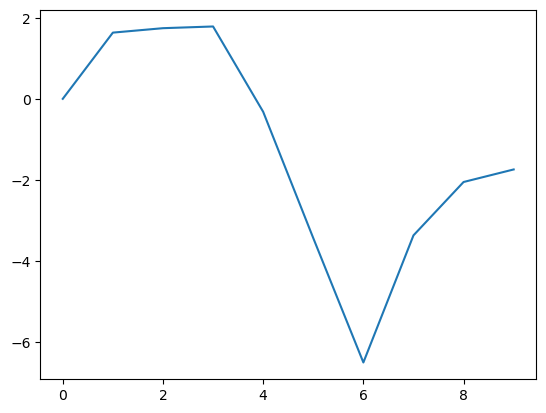

In [3]:
rng = np.random.default_rng(12345)

T = 10
x = np.zeros((T,))

# true stationarity:
true_theta = 0.95
# true standard deviation of the innovation:
true_sigma = 2.0
# true process mean:
true_center = 0.0

for t in range(1, T):
    x[t] = true_theta * x[t - 1] + np.random.normal(loc=true_center, scale=true_sigma)

y_obs = rng.poisson(np.exp(x))

plt.plot(np.arange(T), x)

In [3]:
with pm.Model() as ar1:
    theta = pm.Normal("theta", 0.0, 1.0)
    tau = pm.Exponential("tau", 0.5)

    x = pm.AR("x", rho=theta, tau=tau, steps=T - 1, init_dist=pm.Normal.dist(0, 100, shape=(T,)))

    y = pm.Poisson("y", mu=pm.math.exp(x), observed=y_obs)

    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 578 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


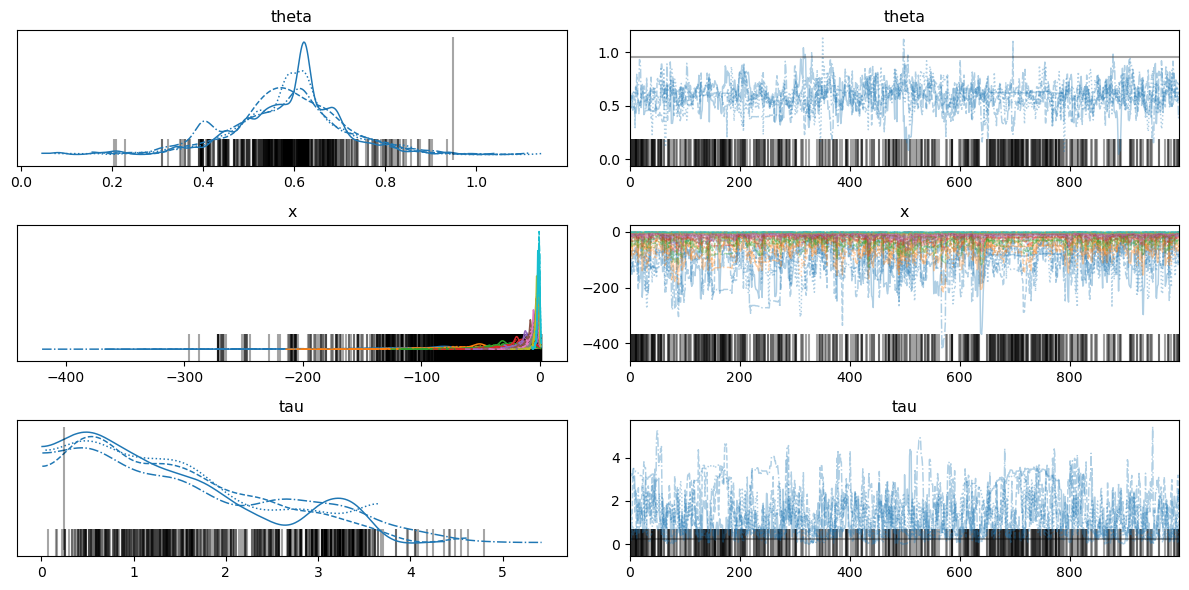

In [4]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {}, true_theta),
        ("tau", {}, true_sigma**-2),
    ],
)
plt.tight_layout()

In [24]:
with pm.Model() as ar1_inla:
    theta = pm.Normal("theta", 0, 1.0)
    # tau = pm.Exponential("tau", 0.5)
    tau = true_sigma**-2

    x = pm.AR("x", rho=theta, tau=tau, steps=T - 1, init_dist=pm.Normal.dist(0, 100, shape=(T,)))

    y = pm.Poisson("y", mu=pm.math.exp(x), observed=y_obs)

    idata = pmx.fit(method="INLA", x=x, Q=tau, return_latent_posteriors=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

/home/michaln/git/pytensor/pytensor/tensor/slinalg.py:1001: LinAlgWarning: Ill-conditioned matrix (rcond=1.38167e-17): result may not be accurate.
  outputs[0][0] = scipy_linalg.solve(


ValueError: Not enough samples to build a trace.

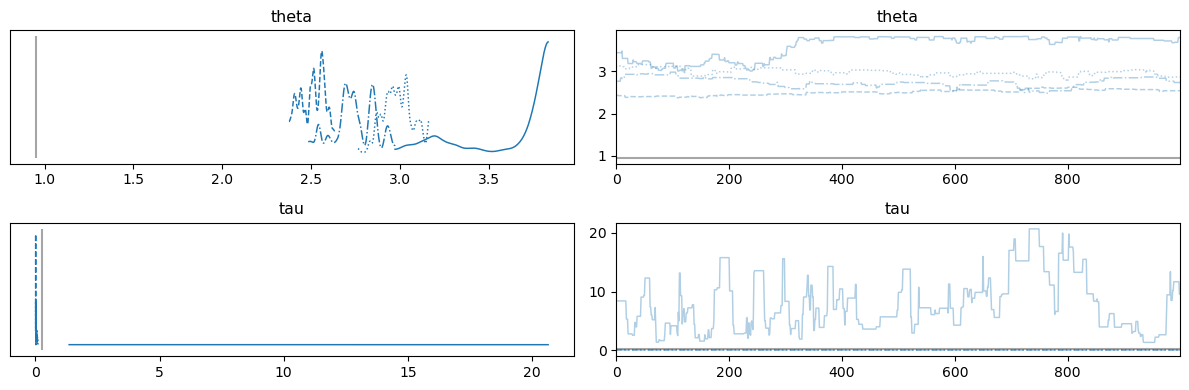

In [21]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {}, true_theta),
        ("tau", {}, true_sigma**-2),
    ],
)
plt.tight_layout()

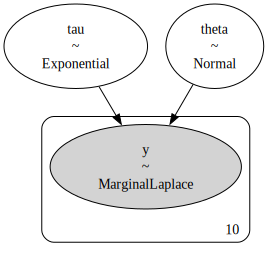

In [10]:
from pymc_extras.model.marginal.marginal_model import marginalize

with pm.Model() as ar1_inla:
    theta = pm.Normal("theta", 0, 1.0)
    tau = pm.Exponential("tau", 0.5)

    x = pm.AR("x", rho=theta, tau=tau, steps=T - 1, init_dist=pm.Normal.dist(0, 100, shape=(T,)))

    y = pm.Poisson("y", mu=pm.math.exp(x), observed=y_obs)

minimizer_kwargs = {"method": "L-BFGS-B", "optimizer_kwargs": {"tol": 1e-8}}
marginalize_kwargs = {
    "Q": ar1_inla.rvs_to_values[tau],
    "minimizer_seed": 42,
    "minimizer_kwargs": minimizer_kwargs,
}
marginal_model = marginalize(ar1_inla, x, use_laplace=True, **marginalize_kwargs)
pm.model_to_graphviz(marginal_model)